In [9]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D , Dropout , Dense
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from keras.models import load_model
import matplotlib.pyplot as plt

### Compile model

In [2]:
CLASSES = 4

In [3]:
base_model = InceptionV3(input_shape=(90, 120, 3),weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

### Load Images

In [4]:
path = "D:/test/dataset/"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.5,
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validate_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [6]:
train_generator = train_datagen.flow_from_directory(path+'train/',
                                                  batch_size=10,
                                                    target_size=(90,120),
                                                  class_mode='categorical')

validation_generator = validate_datagen.flow_from_directory(path+'val/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

test_generator = test_datagen.flow_from_directory(path+'test/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

Found 424 images belonging to 4 classes.
Found 124 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


### Train model (only the top layers)

In [7]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=50,
  validation_steps=validation_generator.n//10
)

Epoch 1/50
42/42 [==============================] - 14s 235ms/step - loss: 5.6775 - accuracy: 0.4798 - val_loss: 0.5553 - val_accuracy: 0.7500
Epoch 2/50
42/42 [==============================] - 8s 197ms/step - loss: 1.0089 - accuracy: 0.7639 - val_loss: 1.0240 - val_accuracy: 0.6750
Epoch 3/50
42/42 [==============================] - 9s 210ms/step - loss: 1.0476 - accuracy: 0.7848 - val_loss: 0.7318 - val_accuracy: 0.8000
Epoch 4/50
42/42 [==============================] - 8s 200ms/step - loss: 0.9433 - accuracy: 0.7747 - val_loss: 0.3553 - val_accuracy: 0.8583
Epoch 5/50
42/42 [==============================] - 9s 204ms/step - loss: 0.9810 - accuracy: 0.8330 - val_loss: 0.3983 - val_accuracy: 0.8333
Epoch 6/50
42/42 [==============================] - 9s 212ms/step - loss: 0.7448 - accuracy: 0.8137 - val_loss: 0.3270 - val_accuracy: 0.8667
Epoch 7/50
42/42 [==============================] - 8s 188ms/step - loss: 0.9373 - accuracy: 0.8098 - val_loss: 0.5695 - val_accuracy: 0.8417
Epoch

### Train (fine-tune bottom 2 layers)

In [10]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=30,
  validation_steps=validation_generator.n//10
)

Epoch 1/30
42/42 [==============================] - 23s 424ms/step - loss: 1.1039 - accuracy: 0.6562 - val_loss: 0.2964 - val_accuracy: 0.8833
Epoch 2/30
42/42 [==============================] - 17s 406ms/step - loss: 0.6282 - accuracy: 0.8005 - val_loss: 0.3651 - val_accuracy: 0.8750
Epoch 3/30
42/42 [==============================] - 17s 406ms/step - loss: 0.6939 - accuracy: 0.8068 - val_loss: 0.3260 - val_accuracy: 0.8667
Epoch 4/30
42/42 [==============================] - 16s 380ms/step - loss: 0.5984 - accuracy: 0.8240 - val_loss: 0.2924 - val_accuracy: 0.8500
Epoch 5/30
42/42 [==============================] - 16s 382ms/step - loss: 0.4222 - accuracy: 0.8424 - val_loss: 0.2981 - val_accuracy: 0.8667
Epoch 6/30
42/42 [==============================] - 16s 382ms/step - loss: 0.4936 - accuracy: 0.8462 - val_loss: 0.2531 - val_accuracy: 0.9000
Epoch 7/30
42/42 [==============================] - 16s 382ms/step - loss: 0.3569 - accuracy: 0.8493 - val_loss: 0.2745 - val_accuracy: 0.8833

### Evaluate model & Visualize performance

In [11]:
model.evaluate(test_generator)

7/7 [==============================] - 1s 125ms/step - loss: 0.4791 - accuracy: 0.8281


[0.479067862033844, 0.828125]

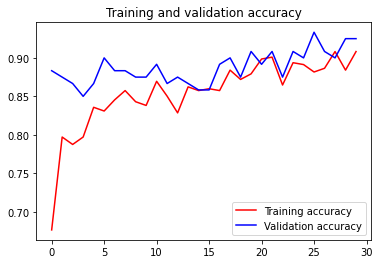

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
fig = plt.gcf()
fig.savefig('from_Inception.png',dpi=fig.dpi)
plt.show()



### Save model

In [13]:
model.save('from_InceptionV3.h5')
model.save_weights('from_InceptionV3_weights.h5')